### Packages

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import importlib, import_ipynb
import data_clean_order_combined as data
#importlib.reload(data)
import tensorflow as tf
from tensorflow.data import experimental
from tensorflow import keras
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split, cross_val_score
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# model building imports
from keras.layers import Embedding, Flatten, Dense, Dropout
from keras.layers import Conv1D, SimpleRNN, Bidirectional, MaxPooling1D, GlobalMaxPool1D, LSTM, GRU
from keras.models import Sequential
from keras.regularizers import L1L2

%matplotlib inline

# matplotlib defaults
plt.style.use("ggplot")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

import warnings 
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
sns.set_style('darkgrid')
warnings.filterwarnings('ignore')

importing Jupyter notebook from data_clean_order_combined.ipynb
Length of original data set 209527
Number of examples with no short description:  19712
Number of examples with no headline:  6


c:\Users\natal\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\natal\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\natal\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\natal\anacond

Stored 'test_df' (DataFrame)
Size of training data for combined:  167616
Size of testing data for combined:  41905
Stored 'rand_shuffled_text' (DataFrame)
Stored 'ordered_super_alpha_text' (DataFrame)
Stored 'ordered_class_alpha_text' (DataFrame)
Stored 'ordered_sem_clusters_desc_text' (DataFrame)
Stored 'ordered_sem_clusters_asc_text' (DataFrame)
Stored 'ordered_sem_clusters_shuffled_per_superclass_text' (DataFrame)


### Loading ordered data from data_clean_order_text.ipynb

In [2]:
%store -r rand_shuffled_text
%store -r ordered_super_alpha_text
%store -r ordered_class_alpha_text
%store -r ordered_sem_clusters_desc_text
%store -r ordered_sem_clusters_asc_text
%store -r ordered_sem_clusters_shuffled_per_superclass_text
%store -r test_df

In [3]:
ordered_sem_clusters_shuffled_per_superclass_text.head(5)

headline  \
76371   Prince Harry Helps Woman In Wheelchair Who Fell, Proves Again He's Pretty Darn Perfect   
57754                        This Nonprofit's Shelter Pup Sleepovers Aim To Help Spur Adoption   
101093   For Past 3 Years, Teen Has Carried Fellow Student Who Has Muscular Dystrophy To Class   
43345                                                 Bridging The Divide At The Checkout Line   
67186                            Dog Who Was Born In A Shelter Can't Stop Kissing His New Baby   

            class superclass  \
76371   GOOD NEWS   POLITICS   
57754   GOOD NEWS   POLITICS   
101093  GOOD NEWS   POLITICS   
43345   GOOD NEWS   POLITICS   
67186   GOOD NEWS   POLITICS   

                                                                                                                   short_description  \
76371                                                       So we're proposing that Prince Harry change his name to Prince Charming.   
57754                                                                                      This is really upping the sleepover game.   
101093                                                                                                                                 
43345   I have a confession: I absolutely LOVE grocery shopping. I don’t know what it is about it – the predictability of the aisles   
67186       When a family in Iowa welcomed a baby girl into their home recently, a dog named Blake was among the first to greet her.   

                                                         cleaned_headline  \
76371   prince harry help woman wheelchair fell prove pretty darn perfect   
57754            nonprofits shelter pup sleepovers aim help spur adoption   
101093      past years teen carry fellow student muscular dystrophy class   
43345                                         bridge divide checkout line   
67186                          dog bear shelter cannot stop kiss new baby   

                                                           cleaned_short_description  \
76371                                  propose prince harry change name prince charm   
57754                                                       really up sleepover game   
101093                                                                                 
43345             confession absolutely love grocery shop know predictability aisles   
67186   family iowa welcome baby girl home recently dog name blake among first greet   

                                                                                                                       combined  
76371           prince harry help woman wheelchair fell prove pretty darn perfect propose prince harry change name prince charm  
57754                                         nonprofits shelter pup sleepovers aim help spur adoption really up sleepover game  
101093                                                           past years teen carry fellow student muscular dystrophy class   
43345                            bridge divide checkout line confession absolutely love grocery shop know predictability aisles  
67186   dog bear shelter cannot stop kiss new baby family iowa welcome baby girl home recently dog name blake among first greet

In [4]:
# Experimental data orderings on headlines TRAIN EXAMPLES
XB_train = rand_shuffled_text['combined']
X1_train = ordered_super_alpha_text['combined']
X2_train = ordered_class_alpha_text['combined']
X3_train = ordered_sem_clusters_desc_text['combined']
X4_train = ordered_sem_clusters_asc_text['combined']
X5_train = ordered_sem_clusters_shuffled_per_superclass_text['combined']

# TRAIN LABELS
YB_train = rand_shuffled_text['class']
Y1_train = ordered_super_alpha_text['class']
Y2_train = ordered_class_alpha_text['class']
Y3_train = ordered_sem_clusters_desc_text['class']
Y4_train = ordered_sem_clusters_asc_text['class']
Y5_train = ordered_sem_clusters_shuffled_per_superclass_text['class']

# TEST EXAMPLES
X_test = test_df['combined']
Y_test = test_df['class']

In [5]:
Y_test[:100]

54871     GENERAL POLITICS
25625     GENERAL POLITICS
48772         QUEER VOICES
114382               STYLE
75653     GENERAL POLITICS
                ...       
6049      GENERAL POLITICS
23369                TASTE
29132     GENERAL POLITICS
137626            WELLNESS
90732     GENERAL POLITICS
Name: class, Length: 100, dtype: object

## Tokenization and Vectorization


### One-hot encoding and indexing of train and test data

In [59]:
# TEST DATA

# one hot encoding using keras tokenizer and pad sequencing
encoder = LabelEncoder()
Y_test = encoder.fit_transform(Y_test)
print("shape of input data: ", X_test.shape)
print("shape of target variable: ", Y_test.shape)

tokenizer = Tokenizer(num_words=1000000, oov_token='<00V>') 
tokenizer.fit_on_texts(X_test) # build the word index
# padding X_test text input data
test_seq = tokenizer.texts_to_sequences(X_test) # converts strinfs into integer lists
test_padseq = pad_sequences(test_seq, maxlen=20) # pads the integer lists to 2D integer tensor 

word_index = tokenizer.word_index
max_words = 150000000  # total number of words to consider in embedding layer
total_words = len(word_index)
maxlen = 20 # max length of sequence 
Y_test = to_categorical(Y_test, num_classes=42)
print("Length of word index:", total_words)

shape of input data:  (41905,)
shape of target variable:  (41905,)
Length of word index: 44012


In [7]:
def plot_loss_accuracy(history):

    # create object of arrays of accuracy and loss
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    # number of epochs in our model
    epochs = range(1 ,len(acc) + 1)
    
    # call matplolib figure object and plot loss and accuracy curves
    plt.figure(figsize=(15,6))
    
    plt.subplot(121)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title("Training and validation accuracy", fontsize=15)
    plt.xlabel('epochs', fontsize=14)
    plt.ylabel("accuracy", fontsize=14)
    plt.legend()
    
    plt.subplot(122)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title("Training and validation loss", fontsize=15)
    plt.xlabel('epochs', fontsize=14)
    plt.ylabel("loss", fontsize=14)
    plt.legend()
    
    plt.show()

# BASELINE ORDER - RAND SHUFFLED

In [8]:
# BASELINE TRAIN DATA
X_train = XB_train
Y_train = YB_train

# one hot encoding using keras tokenizer and pad sequencing
encoder = LabelEncoder()
Y_train = encoder.fit_transform(Y_train)
print("shape of input data: ", X_train.shape)
print("shape of target variable: ", Y_train.shape)

tokenizer = Tokenizer(num_words=1000000, oov_token='<00V>') 
tokenizer.fit_on_texts(X_train) # build the word index
# padding X_train text input data
train_seq = tokenizer.texts_to_sequences(X_train) # converts strinfs into integer lists
train_padseq = pad_sequences(train_seq, maxlen=20) # pads the integer lists to 2D integer tensor 

word_index = tokenizer.word_index
max_words = 15000000  # total number of words to consider in embedding layer
total_words = len(word_index) + 1000
maxlen = 20 # max length of sequence 
Y_train = to_categorical(Y_train, num_classes=42)
print("Length of word index:", total_words)

shape of input data:  (167616,)
shape of target variable:  (167616,)
Length of word index: 89122


### Model 2, training using Conv1D, Bi-directional RNN, LSTMs and GRU layer

In [9]:
model2B = Sequential()
model2B.add(Embedding(total_words, 100, input_length=maxlen))
model2B.add(Bidirectional(LSTM(64, dropout=0.1, recurrent_dropout=0.10, activation='tanh', return_sequences=True)))
model2B.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model2B.add(Bidirectional(SimpleRNN(64, dropout=0.2, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model2B.add(Conv1D(72, 3, activation='relu'))
model2B.add(MaxPooling1D(2))
model2B.add(SimpleRNN(64, activation='tanh', dropout=0.2, recurrent_dropout=0.20, return_sequences=True))
model2B.add(GRU(64, recurrent_dropout=0.20, recurrent_regularizer='l1_l2'))
model2B.add(Dropout(0.2))
model2B.add(Dense(42, activation='softmax'))
model2B.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 100)           8912200   
                                                                 
 bidirectional (Bidirectiona  (None, 20, 128)          84480     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 20, 128)          98816     
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 20, 128)          24704     
 nal)                                                            
                                                                 
 conv1d (Conv1D)             (None, 18, 72)            27720     
                                                        

In [10]:
model2B.compile(optimizer='rmsprop',
            loss='categorical_crossentropy',
            metrics=['accuracy']
            )
#SETUP A EARLY STOPPING CALL and model check point API
earlystopping = keras.callbacks.EarlyStopping(monitor='accuracy',
                                             patience=5,
                                              verbose=1,
                                              mode='min'
                                             )
checkpointer = ModelCheckpoint(filepath='bestvalue',moniter='val_loss', verbose=0, save_best_only=True)
callback_list = [checkpointer, earlystopping]
callback_list = [earlystopping]

# fit model to the data
history2B = model2B.fit(train_padseq, Y_train, 
                   batch_size=128, 
                    epochs=15,
                    validation_split=0.2
                   )

Epoch 1/15
1048/1048 [==============================] - 326s 286ms/step - loss: 2.8547 - accuracy: 0.3586 - val_loss: 2.1045 - val_accuracy: 0.4700
Epoch 2/15
1048/1048 [==============================] - 296s 282ms/step - loss: 1.9516 - accuracy: 0.5078 - val_loss: 1.9034 - val_accuracy: 0.5199
Epoch 3/15
1048/1048 [==============================] - 293s 280ms/step - loss: 1.7275 - accuracy: 0.5609 - val_loss: 1.8156 - val_accuracy: 0.5422
Epoch 4/15
1048/1048 [==============================] - 298s 285ms/step - loss: 1.5721 - accuracy: 0.5992 - val_loss: 1.7675 - val_accuracy: 0.5523
Epoch 5/15
1048/1048 [==============================] - 301s 287ms/step - loss: 1.4530 - accuracy: 0.6294 - val_loss: 1.7648 - val_accuracy: 0.5575
Epoch 6/15
1048/1048 [==============================] - 300s 286ms/step - loss: 1.3495 - accuracy: 0.6577 - val_loss: 1.7693 - val_accuracy: 0.5619
Epoch 7/15
1048/1048 [==============================] - 301s 287ms/step - loss: 1.2545 - accuracy: 0.6824 - val_

Test loss and accuracy: 5.563229560852051 0.07583820819854736


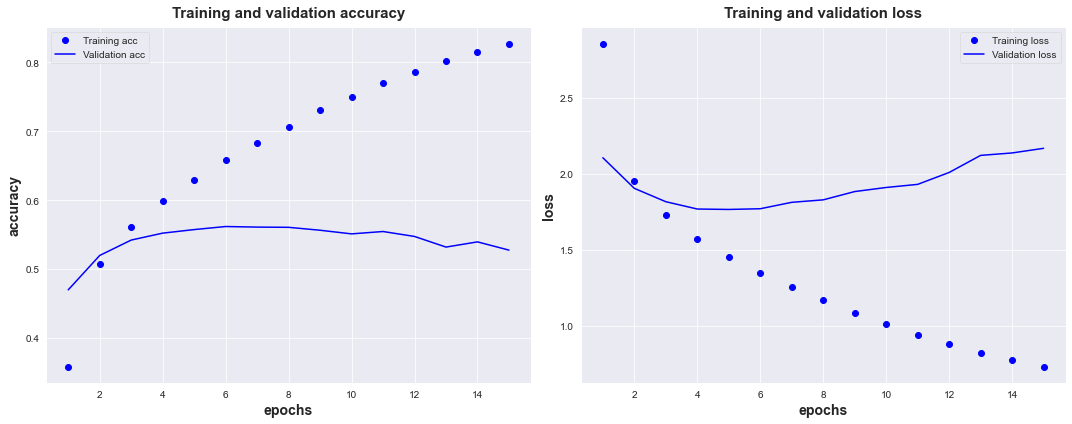

(41905,) (41905,)
[13 13 25 29 13] [38 13  8 13 13]
              precision    recall  f1-score   support

           0       0.01      0.02      0.01       317
           1       0.01      0.02      0.02       262
           2       0.04      0.03      0.03       900
           3       0.03      0.03      0.03      1134
           4       0.00      0.00      0.00       218
           5       0.04      0.05      0.04      1007
           6       0.01      0.01      0.01       732
           7       0.01      0.02      0.01       220
           8       0.04      0.04      0.04       690
           9       0.00      0.00      0.00       198
          10       0.07      0.07      0.07       296
          11       0.00      0.00      0.00       276
          12       0.04      0.02      0.03      1257
          13       0.23      0.21      0.22      7116
          14       0.01      0.02      0.01       282
          15       0.02      0.03      0.03       505
          16       0.06      

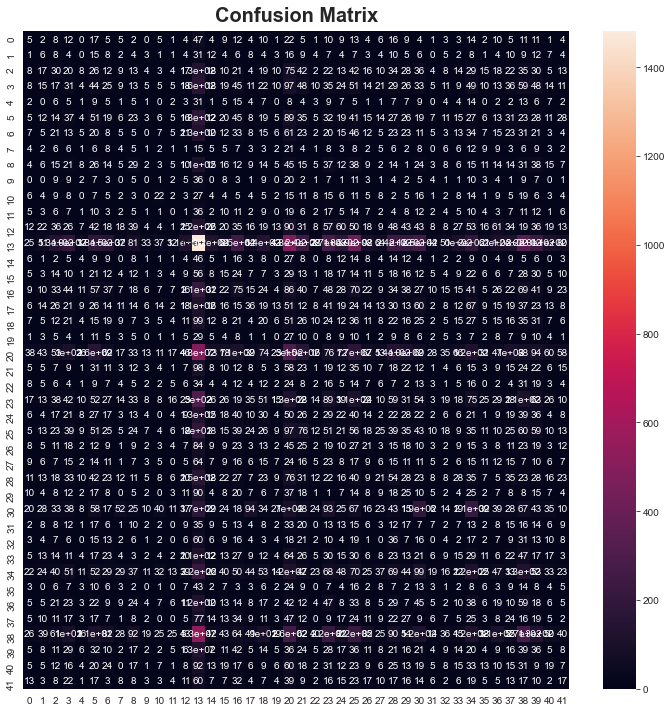

In [14]:
# evalute the model
test_loss, test_acc = model2B.evaluate(test_padseq, Y_test, verbose=0)
print("Test loss and accuracy:", test_loss, test_acc)

plot_loss_accuracy(history2B)

Y_pred = model2B.predict(test_padseq)
Y_pred = np.argmax(Y_pred,axis=1)
Y_test = np.argmax(Y_test,axis=1)
print(Y_test.shape, Y_pred.shape)
print(Y_test[:5], Y_pred[:5])

print(classification_report(Y_test, Y_pred))

plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix(Y_test, Y_pred), annot=True);
plt.title('Confusion Matrix', fontsize=20);

Stopped: NO

Best training accuracy: 0.8273

Best validation accuracy: 0.5619 (epoch 6)

Test accuracy: 0.0758

Training time: 75 m 12.1 s

# EXPERIMENT ORDER 1

In [16]:
# ORDER 1 TRAIN DATA
X_train = X1_train
Y_train = Y1_train

# one hot encoding using keras tokenizer and pad sequencing
encoder = LabelEncoder()
Y_train = encoder.fit_transform(Y_train)
print("shape of input data: ", X_train.shape)
print("shape of target variable: ", Y_train.shape)

tokenizer = Tokenizer(num_words=1000000, oov_token='<00V>') 
tokenizer.fit_on_texts(X_train) # build the word index
# padding X_train text input data
train_seq = tokenizer.texts_to_sequences(X_train) # converts strinfs into integer lists
train_padseq = pad_sequences(train_seq, maxlen=20) # pads the integer lists to 2D integer tensor 

word_index = tokenizer.word_index
max_words = 15000000  # total number of words to consider in embedding layer
total_words = len(word_index) + 1000
maxlen = 20 # max length of sequence 
Y_train = to_categorical(Y_train, num_classes=42)
print("Length of word index:", total_words)

shape of input data:  (167616,)
shape of target variable:  (167616,)
Length of word index: 89122


### Model 2, training using Conv1D, Bi-directional RNN, LSTMs and GRU layer

In [17]:
model1 = Sequential()
model1.add(Embedding(total_words, 100, input_length=maxlen))
model1.add(Bidirectional(LSTM(64, dropout=0.1, recurrent_dropout=0.10, activation='tanh', return_sequences=True)))
model1.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model1.add(Bidirectional(SimpleRNN(64, dropout=0.2, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model1.add(Conv1D(72, 3, activation='relu'))
model1.add(MaxPooling1D(2))
model1.add(SimpleRNN(64, activation='tanh', dropout=0.2, recurrent_dropout=0.20, return_sequences=True))
model1.add(GRU(64, recurrent_dropout=0.20, recurrent_regularizer='l1_l2'))
model1.add(Dropout(0.2))
model1.add(Dense(42, activation='softmax'))
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 20, 100)           8912200   
                                                                 
 bidirectional_3 (Bidirectio  (None, 20, 128)          84480     
 nal)                                                            
                                                                 
 bidirectional_4 (Bidirectio  (None, 20, 128)          98816     
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 20, 128)          24704     
 nal)                                                            
                                                                 
 conv1d_1 (Conv1D)           (None, 18, 72)            27720     
                                                      

In [18]:
model1.compile(optimizer='rmsprop',
            loss='categorical_crossentropy',
            metrics=['accuracy']
            )
#SETUP A EARLY STOPPING CALL and model check point API
earlystopping = keras.callbacks.EarlyStopping(monitor='accuracy',
                                             patience=5,
                                              verbose=1,
                                              mode='min'
                                             )
checkpointer = ModelCheckpoint(filepath='bestvalue',moniter='val_loss', verbose=0, save_best_only=True)
callback_list = [checkpointer, earlystopping]
callback_list = [earlystopping]

# fit model to the data
history1 = model1.fit(train_padseq, Y_train, 
                   batch_size=128, 
                    epochs=15,
                    validation_split=0.2,
                    shuffle=False
                   )

Epoch 1/15
1048/1048 [==============================] - 322s 284ms/step - loss: 1.6325 - accuracy: 0.5731 - val_loss: 6.3138 - val_accuracy: 0.3266
Epoch 2/15
1048/1048 [==============================] - 298s 284ms/step - loss: 1.0562 - accuracy: 0.6580 - val_loss: 6.6835 - val_accuracy: 0.3190
Epoch 3/15
1048/1048 [==============================] - 298s 285ms/step - loss: 0.9605 - accuracy: 0.6977 - val_loss: 7.7179 - val_accuracy: 0.3310
Epoch 4/15
1048/1048 [==============================] - 298s 285ms/step - loss: 0.8798 - accuracy: 0.7353 - val_loss: 7.7588 - val_accuracy: 0.3249
Epoch 5/15
1048/1048 [==============================] - 302s 288ms/step - loss: 0.7934 - accuracy: 0.7751 - val_loss: 7.6547 - val_accuracy: 0.3259
Epoch 6/15
1048/1048 [==============================] - 304s 290ms/step - loss: 0.7790 - accuracy: 0.7823 - val_loss: 7.9734 - val_accuracy: 0.3258
Epoch 7/15
1048/1048 [==============================] - 311s 297ms/step - loss: 0.7166 - accuracy: 0.8052 - val_

Test loss and accuracy: 10.511411666870117 0.09316311031579971


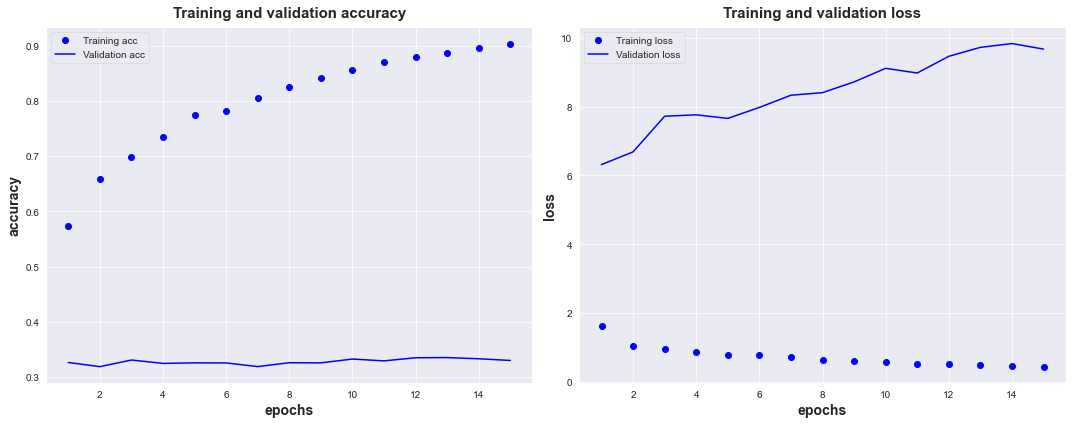

(41905,) (41905,)
[13 13 25 29 13] [14 13 14 13 13]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       317
           1       0.00      0.00      0.00       262
           2       0.00      0.00      0.00       900
           3       0.00      0.00      0.00      1134
           4       0.00      0.00      0.00       218
           5       0.00      0.00      0.00      1007
           6       0.00      0.00      0.00       732
           7       0.00      0.00      0.00       220
           8       0.00      0.00      0.00       690
           9       0.00      0.00      0.00       198
          10       0.00      0.00      0.00       296
          11       0.02      0.17      0.03       276
          12       0.00      0.00      0.00      1257
          13       0.19      0.50      0.28      7116
          14       0.01      0.17      0.01       282
          15       0.00      0.00      0.00       505
          16       0.00      

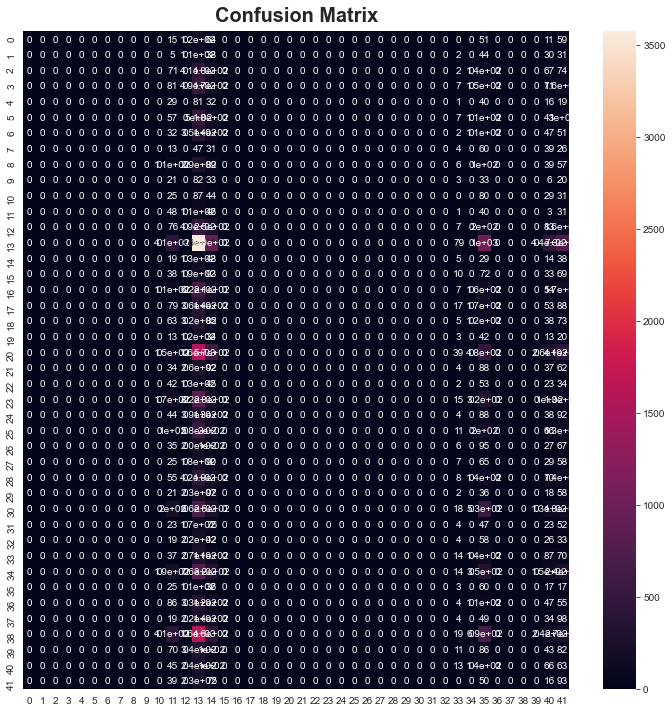

In [21]:
# evalute the model
test_loss, test_acc = model1.evaluate(test_padseq, Y_test, verbose=0)
print("Test loss and accuracy:", test_loss, test_acc)

plot_loss_accuracy(history1)

Y_pred = model1.predict(test_padseq)
Y_pred = np.argmax(Y_pred,axis=1)
Y_test = np.argmax(Y_test,axis=1)
print(Y_test.shape, Y_pred.shape)
print(Y_test[:5], Y_pred[:5])

print(classification_report(Y_test, Y_pred))

plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix(Y_test, Y_pred), annot=True);
plt.title('Confusion Matrix', fontsize=20);

Stopped: NO

Best training accuracy: 0.9037

Best validation accuracy: 0.3333 (epoch 14)

Test accuracy: 0.0758

Training time: 75 m 47.5 s

# EXPERIMENT ORDER 2

In [38]:
# ORDER 2 TRAIN DATA
X_train = X2_train
Y_train = Y2_train

# one hot encoding using keras tokenizer and pad sequencing
encoder = LabelEncoder()
Y_train = encoder.fit_transform(Y_train)
print("shape of input data: ", X_train.shape)
print("shape of target variable: ", Y_train.shape)

tokenizer = Tokenizer(num_words=1000000, oov_token='<00V>') 
tokenizer.fit_on_texts(X_train) # build the word index
# padding X_train text input data
train_seq = tokenizer.texts_to_sequences(X_train) # converts strinfs into integer lists
train_padseq = pad_sequences(train_seq, maxlen=20) # pads the integer lists to 2D integer tensor 

word_index = tokenizer.word_index
max_words = 15000000  # total number of words to consider in embedding layer
total_words = len(word_index) + 1000
maxlen = 20 # max length of sequence 
Y_train = to_categorical(Y_train, num_classes=42)
print("Length of word index:", total_words)

shape of input data:  (167616,)
shape of target variable:  (167616,)
Length of word index: 89122


### Model 2, training using Conv1D, Bi-directional RNN, LSTMs and GRU layer

In [23]:
model2 = Sequential()
model2.add(Embedding(total_words, 100, input_length=maxlen))
model2.add(Bidirectional(LSTM(64, dropout=0.1, recurrent_dropout=0.10, activation='tanh', return_sequences=True)))
model2.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model2.add(Bidirectional(SimpleRNN(64, dropout=0.2, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model2.add(Conv1D(72, 3, activation='relu'))
model2.add(MaxPooling1D(2))
model2.add(SimpleRNN(64, activation='tanh', dropout=0.2, recurrent_dropout=0.20, return_sequences=True))
model2.add(GRU(64, recurrent_dropout=0.20, recurrent_regularizer='l1_l2'))
model2.add(Dropout(0.2))
model2.add(Dense(42, activation='softmax'))
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 20, 100)           8912200   
                                                                 
 bidirectional_6 (Bidirectio  (None, 20, 128)          84480     
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 20, 128)          98816     
 nal)                                                            
                                                                 
 bidirectional_8 (Bidirectio  (None, 20, 128)          24704     
 nal)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 18, 72)            27720     
                                                      

In [24]:
model2.compile(optimizer='rmsprop',
            loss='categorical_crossentropy',
            metrics=['accuracy']
            )
#SETUP A EARLY STOPPING CALL and model check point API
earlystopping = keras.callbacks.EarlyStopping(monitor='accuracy',
                                             patience=5,
                                              verbose=1,
                                              mode='min'
                                             )
checkpointer = ModelCheckpoint(filepath='bestvalue',moniter='val_loss', verbose=0, save_best_only=True)
callback_list = [checkpointer, earlystopping]
callback_list = [earlystopping]

# fit model to the data
history2 = model2.fit(train_padseq, Y_train, 
                   batch_size=128, 
                    epochs=15,
                    validation_split=0.2,
                    shuffle=False
                   )

Epoch 1/15
1048/1048 [==============================] - 341s 301ms/step - loss: 1.2619 - accuracy: 0.8545 - val_loss: 5.3574 - val_accuracy: 0.1636
Epoch 2/15
1048/1048 [==============================] - 312s 298ms/step - loss: 0.6454 - accuracy: 0.8998 - val_loss: 6.0786 - val_accuracy: 0.1636
Epoch 3/15
1048/1048 [==============================] - 302s 288ms/step - loss: 0.5398 - accuracy: 0.9128 - val_loss: 6.3611 - val_accuracy: 0.1636
Epoch 4/15
1048/1048 [==============================] - 301s 287ms/step - loss: 0.4898 - accuracy: 0.9203 - val_loss: 6.6879 - val_accuracy: 0.1636
Epoch 5/15
1048/1048 [==============================] - 299s 286ms/step - loss: 0.4550 - accuracy: 0.9262 - val_loss: 7.4882 - val_accuracy: 0.1636
Epoch 6/15
1048/1048 [==============================] - 301s 288ms/step - loss: 0.4384 - accuracy: 0.9274 - val_loss: 8.0258 - val_accuracy: 0.1636
Epoch 7/15
1048/1048 [==============================] - 303s 289ms/step - loss: 0.4443 - accuracy: 0.9256 - val_

Test loss and accuracy: 8.937901496887207 0.0479656383395195


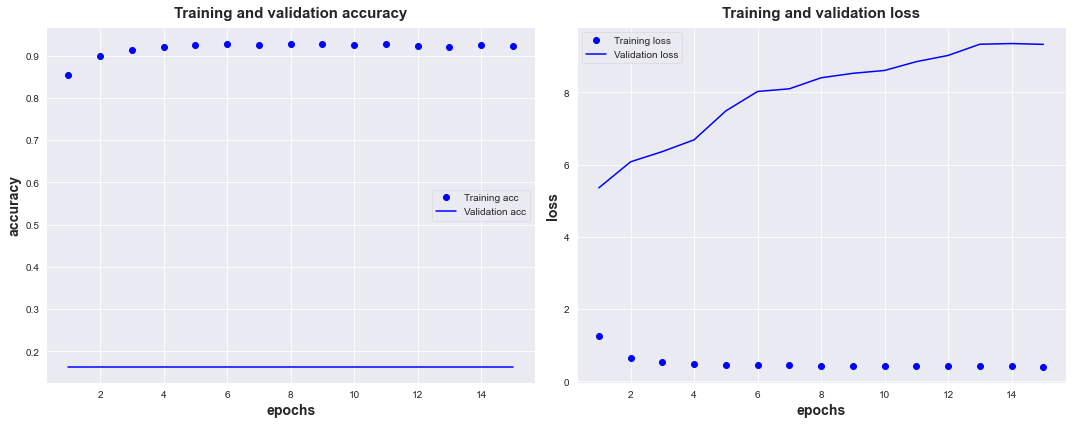

(41905,) (41905,)
[13 13 25 29 13] [34 34 34 34 34]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       317
           1       0.00      0.00      0.00       262
           2       0.00      0.00      0.00       900
           3       0.00      0.00      0.00      1134
           4       0.00      0.00      0.00       218
           5       0.00      0.00      0.00      1007
           6       0.00      0.00      0.00       732
           7       0.00      0.00      0.00       220
           8       0.00      0.00      0.00       690
           9       0.00      0.00      0.00       198
          10       0.00      0.00      0.00       296
          11       0.00      0.00      0.00       276
          12       0.00      0.00      0.00      1257
          13       0.00      0.00      0.00      7116
          14       0.00      0.00      0.00       282
          15       0.00      0.00      0.00       505
          16       0.00      

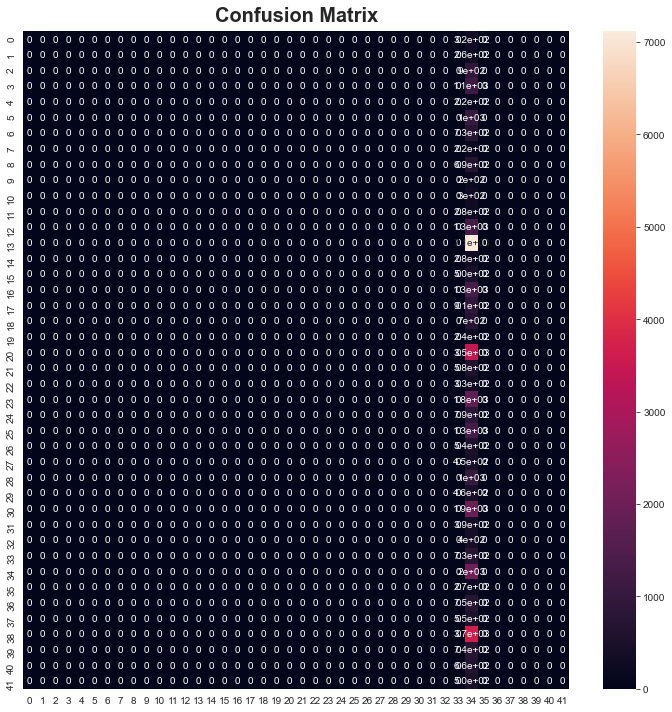

In [32]:
# evalute the model
test_loss, test_acc = model2.evaluate(test_padseq, Y_test, verbose=0)
print("Test loss and accuracy:", test_loss, test_acc)

plot_loss_accuracy(history2)

Y_pred = model2.predict(test_padseq)
Y_pred = np.argmax(Y_pred,axis=1)
Y_test = np.argmax(Y_test,axis=1)
print(Y_test.shape, Y_pred.shape)
print(Y_test[:5], Y_pred[:5])

print(classification_report(Y_test, Y_pred))

plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix(Y_test, Y_pred), annot=True);
plt.title('Confusion Matrix', fontsize=20);

Stopped: 

Best training accuracy: 0.9288 (epoch 8)

Best validation accuracy: -

Test accuracy: 0.0479

Training time: 74 m 43.3 s

# EXPERIMENT ORDER 3

In [40]:
# ORDER 3 TRAIN DATA
X_train = X3_train
Y_train = Y3_train

# one hot encoding using keras tokenizer and pad sequencing
encoder = LabelEncoder()
Y_train = encoder.fit_transform(Y_train)
print("shape of input data: ", X_train.shape)
print("shape of target variable: ", Y_train.shape)

tokenizer = Tokenizer(num_words=1000000, oov_token='<00V>') 
tokenizer.fit_on_texts(X_train) # build the word index
# padding X_train text input data
train_seq = tokenizer.texts_to_sequences(X_train) # converts strinfs into integer lists
train_padseq = pad_sequences(train_seq, maxlen=20) # pads the integer lists to 2D integer tensor 

word_index = tokenizer.word_index
max_words = 15000000  # total number of words to consider in embedding layer
total_words = len(word_index) + 1000
maxlen = 20 # max length of sequence 
Y_train = to_categorical(Y_train, num_classes=42)
print("Length of word index:", total_words)

shape of input data:  (167616,)
shape of target variable:  (167616,)
Length of word index: 89122


### Model 2, training using Conv1D, Bi-directional RNN, LSTMs and GRU layer

In [42]:
model3 = Sequential()
model3.add(Embedding(total_words, 100, input_length=maxlen))
model3.add(Bidirectional(LSTM(64, dropout=0.1, recurrent_dropout=0.10, activation='tanh', return_sequences=True)))
model3.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model3.add(Bidirectional(SimpleRNN(64, dropout=0.2, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model3.add(Conv1D(72, 3, activation='relu'))
model3.add(MaxPooling1D(2))
model3.add(SimpleRNN(64, activation='tanh', dropout=0.2, recurrent_dropout=0.20, return_sequences=True))
model3.add(GRU(64, recurrent_dropout=0.20, recurrent_regularizer='l1_l2'))
model3.add(Dropout(0.2))
model3.add(Dense(42, activation='softmax'))
model3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 20, 100)           8912200   
                                                                 
 bidirectional_9 (Bidirectio  (None, 20, 128)          84480     
 nal)                                                            
                                                                 
 bidirectional_10 (Bidirecti  (None, 20, 128)          98816     
 onal)                                                           
                                                                 
 bidirectional_11 (Bidirecti  (None, 20, 128)          24704     
 onal)                                                           
                                                                 
 conv1d_3 (Conv1D)           (None, 18, 72)            27720     
                                                      

In [43]:
model3.compile(optimizer='rmsprop',
            loss='categorical_crossentropy',
            metrics=['accuracy']
            )
#SETUP A EARLY STOPPING CALL and model check point API
earlystopping = keras.callbacks.EarlyStopping(monitor='accuracy',
                                             patience=5,
                                              verbose=1,
                                              mode='min'
                                             )
checkpointer = ModelCheckpoint(filepath='bestvalue',moniter='val_loss', verbose=0, save_best_only=True)
callback_list = [checkpointer, earlystopping]
callback_list = [earlystopping]

# fit model to the data
history3 = model3.fit(train_padseq, Y_train, 
                   batch_size=128, 
                    epochs=15,
                    validation_split=0.2,
                    shuffle=False
                   )

Epoch 1/15
1048/1048 [==============================] - 346s 301ms/step - loss: 1.0530 - accuracy: 0.8920 - val_loss: 7.5065 - val_accuracy: 0.0444
Epoch 2/15
1048/1048 [==============================] - 302s 288ms/step - loss: 0.4723 - accuracy: 0.9303 - val_loss: 8.6309 - val_accuracy: 0.0444
Epoch 3/15
1048/1048 [==============================] - 305s 291ms/step - loss: 0.3893 - accuracy: 0.9442 - val_loss: 9.5638 - val_accuracy: 0.0444
Epoch 4/15
1048/1048 [==============================] - 304s 290ms/step - loss: 0.3585 - accuracy: 0.9477 - val_loss: 10.0545 - val_accuracy: 0.0444
Epoch 5/15
1048/1048 [==============================] - 305s 291ms/step - loss: 0.3485 - accuracy: 0.9470 - val_loss: 10.1697 - val_accuracy: 0.0444
Epoch 6/15
1048/1048 [==============================] - 304s 291ms/step - loss: 0.3377 - accuracy: 0.9518 - val_loss: 10.7121 - val_accuracy: 0.0444
Epoch 7/15
1048/1048 [==============================] - 305s 291ms/step - loss: 0.3297 - accuracy: 0.9507 - v

Test loss and accuracy: 9.632699966430664 0.03076005168259144


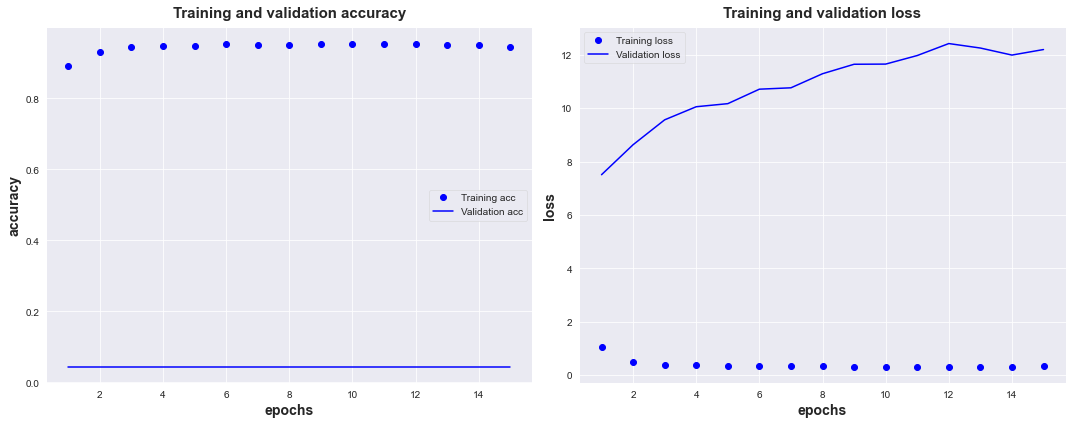

(41905,) (41905,)
[13 13 25 29 13] [25 25 25 25 25]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       317
           1       0.00      0.00      0.00       262
           2       0.00      0.00      0.00       900
           3       0.00      0.00      0.00      1134
           4       0.00      0.00      0.00       218
           5       0.00      0.00      0.00      1007
           6       0.00      0.00      0.00       732
           7       0.00      0.00      0.00       220
           8       0.00      0.00      0.00       690
           9       0.00      0.00      0.00       198
          10       0.00      0.00      0.00       296
          11       0.00      0.00      0.00       276
          12       0.00      0.00      0.00      1257
          13       0.00      0.00      0.00      7116
          14       0.00      0.00      0.00       282
          15       0.00      0.00      0.00       505
          16       0.00      

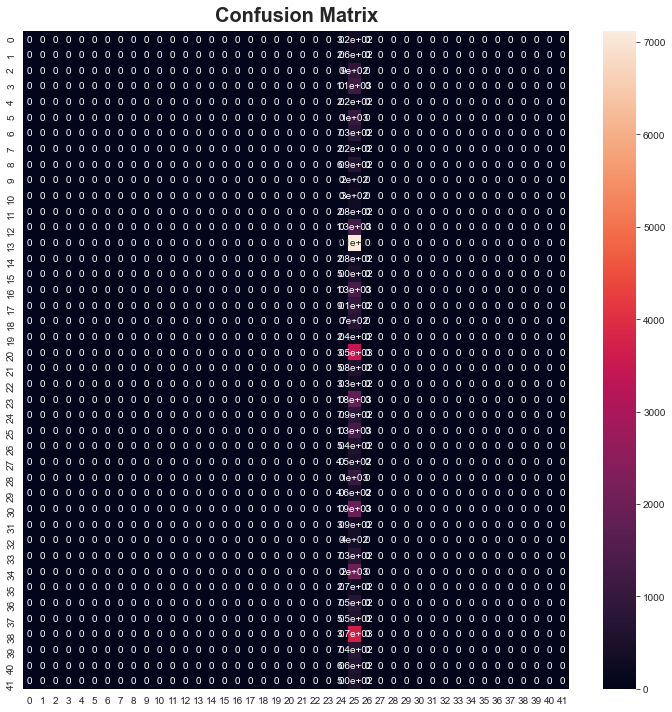

In [46]:
# evalute the model
test_loss, test_acc = model3.evaluate(test_padseq, Y_test, verbose=0)
print("Test loss and accuracy:", test_loss, test_acc)

plot_loss_accuracy(history3)

Y_pred = model3.predict(test_padseq)
Y_pred = np.argmax(Y_pred,axis=1)
Y_test = np.argmax(Y_test,axis=1)
print(Y_test.shape, Y_pred.shape)
print(Y_test[:5], Y_pred[:5])

print(classification_report(Y_test, Y_pred))

plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix(Y_test, Y_pred), annot=True);
plt.title('Confusion Matrix', fontsize=20);

Stopped: 

Best training accuracy:

Best validation accuracy: 

Test accuracy:

Training time:

# EXPERIMENT ORDER 4

In [47]:
# ORDER 4 TRAIN DATA
X_train = X4_train
Y_train = Y4_train

# one hot encoding using keras tokenizer and pad sequencing
encoder = LabelEncoder()
Y_train = encoder.fit_transform(Y_train)
print("shape of input data: ", X_train.shape)
print("shape of target variable: ", Y_train.shape)

tokenizer = Tokenizer(num_words=1000000, oov_token='<00V>') 
tokenizer.fit_on_texts(X_train) # build the word index
# padding X_train text input data
train_seq = tokenizer.texts_to_sequences(X_train) # converts strinfs into integer lists
train_padseq = pad_sequences(train_seq, maxlen=20) # pads the integer lists to 2D integer tensor 

word_index = tokenizer.word_index
max_words = 15000000  # total number of words to consider in embedding layer
total_words = len(word_index) + 1000
maxlen = 20 # max length of sequence 
Y_train = to_categorical(Y_train, num_classes=42)
print("Length of word index:", total_words)

shape of input data:  (167616,)
shape of target variable:  (167616,)
Length of word index: 89122


### Model 2, training using Conv1D, Bi-directional RNN, LSTMs and GRU layer


In [48]:
model4 = Sequential()
model4.add(Embedding(total_words, 100, input_length=maxlen))
model4.add(Bidirectional(LSTM(64, dropout=0.1, recurrent_dropout=0.10, activation='tanh', return_sequences=True)))
model4.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model4.add(Bidirectional(SimpleRNN(64, dropout=0.2, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model4.add(Conv1D(72, 3, activation='relu'))
model4.add(MaxPooling1D(2))
model4.add(SimpleRNN(64, activation='tanh', dropout=0.2, recurrent_dropout=0.20, return_sequences=True))
model4.add(GRU(64, recurrent_dropout=0.20, recurrent_regularizer='l1_l2'))
model4.add(Dropout(0.2))
model4.add(Dense(42, activation='softmax'))
model4.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 20, 100)           8912200   
                                                                 
 bidirectional_12 (Bidirecti  (None, 20, 128)          84480     
 onal)                                                           
                                                                 
 bidirectional_13 (Bidirecti  (None, 20, 128)          98816     
 onal)                                                           
                                                                 
 bidirectional_14 (Bidirecti  (None, 20, 128)          24704     
 onal)                                                           
                                                                 
 conv1d_4 (Conv1D)           (None, 18, 72)            27720     
                                                      

In [49]:
model4.compile(optimizer='rmsprop',
            loss='categorical_crossentropy',
            metrics=['accuracy']
            )
#SETUP A EARLY STOPPING CALL and model check point API
earlystopping = keras.callbacks.EarlyStopping(monitor='accuracy',
                                             patience=5,
                                              verbose=1,
                                              mode='min'
                                             )
checkpointer = ModelCheckpoint(filepath='bestvalue',moniter='val_loss', verbose=0, save_best_only=True)
callback_list = [checkpointer, earlystopping]
callback_list = [earlystopping]

# fit model to the data
history4 = model4.fit(train_padseq, Y_train, 
                   batch_size=128, 
                    epochs=15,
                    validation_split=0.2,
                    shuffle=False
                   )

Epoch 1/15
1048/1048 [==============================] - 328s 285ms/step - loss: 1.2995 - accuracy: 0.8491 - val_loss: 4.3109 - val_accuracy: 0.0629
Epoch 2/15
1048/1048 [==============================] - 297s 284ms/step - loss: 0.6531 - accuracy: 0.8953 - val_loss: 4.8486 - val_accuracy: 0.0629
Epoch 3/15
1048/1048 [==============================] - 299s 285ms/step - loss: 0.5608 - accuracy: 0.9085 - val_loss: 5.0918 - val_accuracy: 0.0629
Epoch 4/15
1048/1048 [==============================] - 297s 284ms/step - loss: 0.5376 - accuracy: 0.9082 - val_loss: 5.4095 - val_accuracy: 0.0629
Epoch 5/15
1048/1048 [==============================] - 300s 286ms/step - loss: 0.4920 - accuracy: 0.9156 - val_loss: 5.7389 - val_accuracy: 0.0629
Epoch 6/15
1048/1048 [==============================] - 303s 289ms/step - loss: 0.4664 - accuracy: 0.9200 - val_loss: 5.8141 - val_accuracy: 0.0629
Epoch 7/15
1048/1048 [==============================] - 300s 286ms/step - loss: 0.4512 - accuracy: 0.9232 - val_

Test loss and accuracy: 7.095562934875488 0.015869228169322014


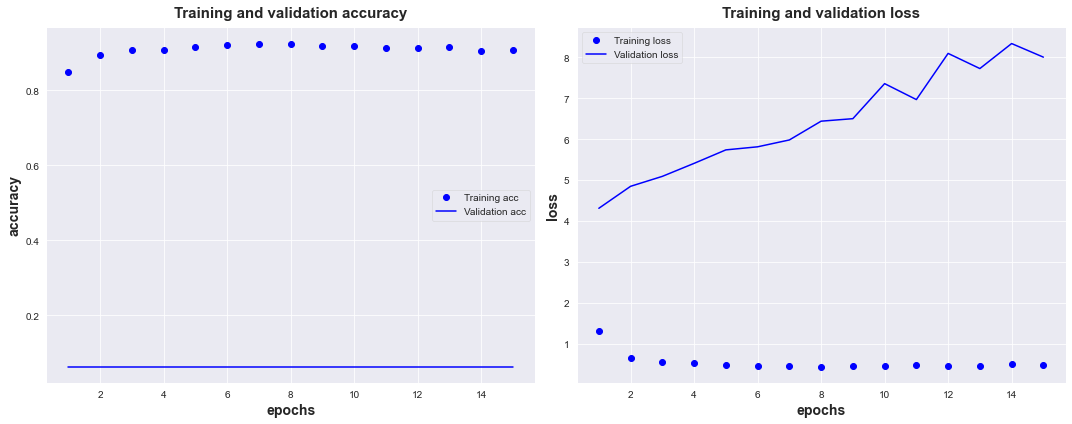

(41905,) (41905,)
[13 13 25 29 13] [40 40 40 40 40]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       317
           1       0.00      0.00      0.00       262
           2       0.00      0.00      0.00       900
           3       0.00      0.00      0.00      1134
           4       0.00      0.00      0.00       218
           5       0.00      0.00      0.00      1007
           6       0.00      0.00      0.00       732
           7       0.00      0.00      0.00       220
           8       0.00      0.00      0.00       690
           9       0.00      0.00      0.00       198
          10       0.00      0.00      0.00       296
          11       0.00      0.00      0.00       276
          12       0.00      0.00      0.00      1257
          13       0.00      0.00      0.00      7116
          14       0.00      0.00      0.00       282
          15       0.00      0.00      0.00       505
          16       0.00      

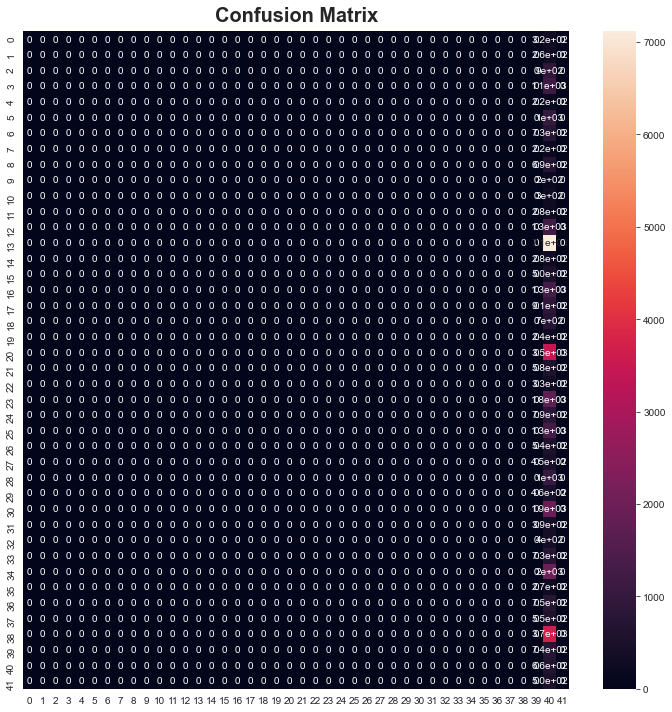

In [57]:
# evalute the model
test_loss, test_acc = model4.evaluate(test_padseq, Y_test, verbose=0)
print("Test loss and accuracy:", test_loss, test_acc)

plot_loss_accuracy(history4)

Y_pred = model4.predict(test_padseq)
Y_pred = np.argmax(Y_pred,axis=1)
Y_test = np.argmax(Y_test,axis=1)
print(Y_test.shape, Y_pred.shape)
print(Y_test[:5], Y_pred[:5])

print(classification_report(Y_test, Y_pred))

plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix(Y_test, Y_pred), annot=True);
plt.title('Confusion Matrix', fontsize=20);

Stopped: 

Best training accuracy:

Best validation accuracy: 

Test accuracy:

Training time:

# EXPERIMENT ORDER 5

In [52]:
# ORDER 5 TRAIN DATA
X_train = X5_train
Y_train = Y5_train

# one hot encoding using keras tokenizer and pad sequencing
encoder = LabelEncoder()
Y_train = encoder.fit_transform(Y_train)
print("shape of input data: ", X_train.shape)
print("shape of target variable: ", Y_train.shape)

tokenizer = Tokenizer(num_words=1000000, oov_token='<00V>') 
tokenizer.fit_on_texts(X_train) # build the word index
# padding X_train text input data
train_seq = tokenizer.texts_to_sequences(X_train) # converts strinfs into integer lists
train_padseq = pad_sequences(train_seq, maxlen=20) # pads the integer lists to 2D integer tensor 

word_index = tokenizer.word_index
max_words = 15000000  # total number of words to consider in embedding layer
total_words = len(word_index) + 1000
maxlen = 20 # max length of sequence 
Y_train = to_categorical(Y_train, num_classes=42)
print("Length of word index:", total_words)

shape of input data:  (167616,)
shape of target variable:  (167616,)
Length of word index: 89122


### Model 2, training using Conv1D, Bi-directional RNN, LSTMs and GRU layer


In [53]:
model5 = Sequential()
model5.add(Embedding(total_words, 100, input_length=maxlen))
model5.add(Bidirectional(LSTM(64, dropout=0.1, recurrent_dropout=0.10, activation='tanh', return_sequences=True)))
model5.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model5.add(Bidirectional(SimpleRNN(64, dropout=0.2, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model5.add(Conv1D(72, 3, activation='relu'))
model5.add(MaxPooling1D(2))
model5.add(SimpleRNN(64, activation='tanh', dropout=0.2, recurrent_dropout=0.20, return_sequences=True))
model5.add(GRU(64, recurrent_dropout=0.20, recurrent_regularizer='l1_l2'))
model5.add(Dropout(0.2))
model5.add(Dense(42, activation='softmax'))
model5.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 20, 100)           8912200   
                                                                 
 bidirectional_15 (Bidirecti  (None, 20, 128)          84480     
 onal)                                                           
                                                                 
 bidirectional_16 (Bidirecti  (None, 20, 128)          98816     
 onal)                                                           
                                                                 
 bidirectional_17 (Bidirecti  (None, 20, 128)          24704     
 onal)                                                           
                                                                 
 conv1d_5 (Conv1D)           (None, 18, 72)            27720     
                                                      

In [54]:
model5.compile(optimizer='rmsprop',
            loss='categorical_crossentropy',
            metrics=['accuracy']
            )
#SETUP A EARLY STOPPING CALL and model check point API
earlystopping = keras.callbacks.EarlyStopping(monitor='accuracy',
                                             patience=5,
                                              verbose=1,
                                              mode='min'
                                             )
checkpointer = ModelCheckpoint(filepath='bestvalue',moniter='val_loss', verbose=0, save_best_only=True)
callback_list = [checkpointer, earlystopping]
callback_list = [earlystopping]

# fit model to the data
history5 = model5.fit(train_padseq, Y_train, 
                   batch_size=128, 
                    epochs=15,
                    validation_split=0.2,
                    shuffle=False
                   )

Epoch 1/15
1048/1048 [==============================] - 328s 290ms/step - loss: 1.0586 - accuracy: 0.8911 - val_loss: 6.7116 - val_accuracy: 0.0444
Epoch 2/15
1048/1048 [==============================] - 289s 276ms/step - loss: 0.5228 - accuracy: 0.9199 - val_loss: 8.0864 - val_accuracy: 0.0444
Epoch 3/15
1048/1048 [==============================] - 288s 275ms/step - loss: 0.4127 - accuracy: 0.9390 - val_loss: 9.2965 - val_accuracy: 0.0444
Epoch 4/15
1048/1048 [==============================] - 289s 276ms/step - loss: 0.3710 - accuracy: 0.9439 - val_loss: 10.1981 - val_accuracy: 0.0444
Epoch 5/15
1048/1048 [==============================] - 290s 277ms/step - loss: 0.3552 - accuracy: 0.9475 - val_loss: 10.8419 - val_accuracy: 0.0444
Epoch 6/15
1048/1048 [==============================] - 289s 276ms/step - loss: 0.3535 - accuracy: 0.9459 - val_loss: 10.7871 - val_accuracy: 0.0444
Epoch 7/15
1048/1048 [==============================] - 290s 277ms/step - loss: 0.3424 - accuracy: 0.9483 - v

Test loss and accuracy: 9.847238540649414 0.03076005168259144


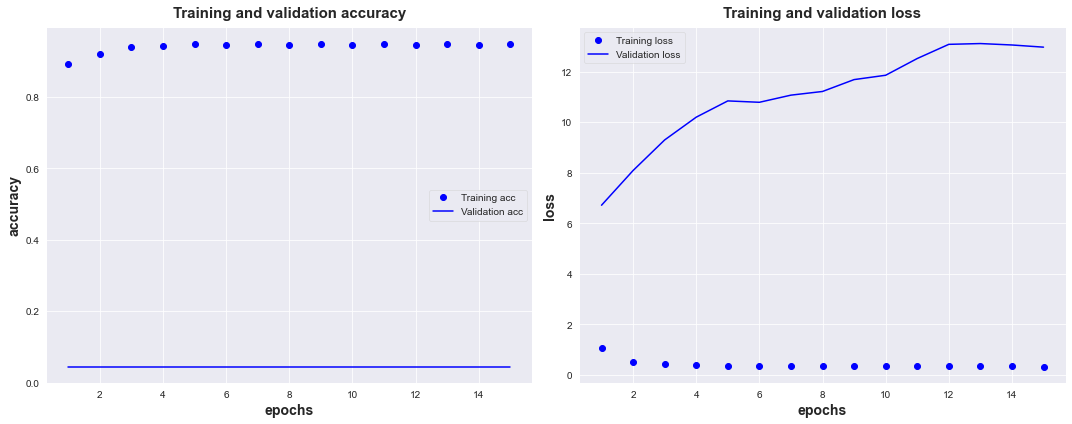

(41905,) (41905,)
[13 13 25 29 13] [25 25 25 25 25]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       317
           1       0.00      0.00      0.00       262
           2       0.00      0.00      0.00       900
           3       0.00      0.00      0.00      1134
           4       0.00      0.00      0.00       218
           5       0.00      0.00      0.00      1007
           6       0.00      0.00      0.00       732
           7       0.00      0.00      0.00       220
           8       0.00      0.00      0.00       690
           9       0.00      0.00      0.00       198
          10       0.00      0.00      0.00       296
          11       0.00      0.00      0.00       276
          12       0.00      0.00      0.00      1257
          13       0.00      0.00      0.00      7116
          14       0.00      0.00      0.00       282
          15       0.00      0.00      0.00       505
          16       0.00      

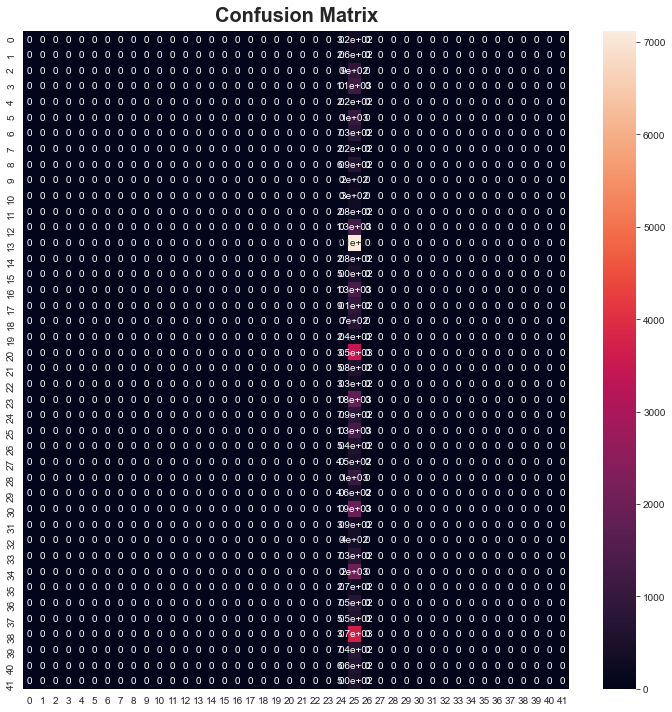

In [60]:
# evalute the model
test_loss, test_acc = model5.evaluate(test_padseq, Y_test, verbose=0)
print("Test loss and accuracy:", test_loss, test_acc)

plot_loss_accuracy(history5)

Y_pred = model5.predict(test_padseq)
Y_pred = np.argmax(Y_pred,axis=1)
Y_test = np.argmax(Y_test,axis=1)
print(Y_test.shape, Y_pred.shape)
print(Y_test[:5], Y_pred[:5])

print(classification_report(Y_test, Y_pred))

plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix(Y_test, Y_pred), annot=True);
plt.title('Confusion Matrix', fontsize=20);

Stopped: 

Best training accuracy:

Best validation accuracy: 

Test accuracy:

Training time: